## Loading libraries

In [38]:
import pandas
from scipy import stats
pandas.__version__

'1.3.4'

## Loading the dataset...

I am providing 2 versions of the dataset:
1. `benchmark-dataset-homogeneous.csv` contains 9 runs of the benchmark on 3 different browsers, on the same laptop, with a low workload
2. `benchmark-dataset-heterogeneous.csv` contains data from the same browsers and machine, with varying workloads, plus data from 2 browsers on my mobile phone.

In [39]:
dataset = pandas.read_csv("benchmark-dataset-homogeneous.csv")  # to use homogeneous dataset
# dataset = pandas.read_csv("benchmark-dataset-heterogeneous.csv") # to use heterogeneous dataset
dataset

,session,run,approach,loop_type,cycles,duration,timestamp,os,browser,useragent
0,2cc8f6,39ef40,Map_Only,async,50,721,2021-12-08T10:55:46.447Z,Windows,Firefox,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...
1,2cc8f6,39ef40,Map_Only,sync,50,42,2021-12-08T10:55:46.489Z,Windows,Firefox,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...
2,2cc8f6,39ef40,Canvas,async,50,806,2021-12-08T10:55:47.295Z,Windows,Firefox,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...
3,2cc8f6,39ef40,Canvas,sync,50,364,2021-12-08T10:55:47.659Z,Windows,Firefox,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...
4,2cc8f6,39ef40,HTML_flex,async,50,1685,2021-12-08T10:55:49.344Z,Windows,Firefox,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...
...,...,...,...,...,...,...,...,...,...,...
103,c94d66,94679d,HTML_absolute,sync,50,346,2021-12-08T12:27:48.934Z,Windows,Chrome,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
104,c94d66,94679d,SVG_slow,async,50,6305,2021-12-08T12:27:55.243Z,Windows,Chrome,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
105,c94d66,94679d,SVG_slow,sync,50,2773,2021-12-08T12:27:58.031Z,Windows,Chrome,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
106,c94d66,94679d,SVG,async,50,3061,2021-12-08T12:28:01.096Z,Windows,Chrome,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


### Which approach is the quickest in each condition?

In [40]:
pivoted_data = dataset.pivot(index=['os','browser','run','loop_type'], columns=['approach'], values='duration')
ranked_data = pivoted_data.rank(axis=1)
ranked_data

approach                          Canvas  HTML_absolute  HTML_flex  Map_Only  \
os      browser run    loop_type                                               
Windows Chrome  19c63b async         2.0            4.0        3.0       1.0   
                       sync          5.0            3.0        2.0       1.0   
                4e2a54 async         2.0            4.0        3.0       1.0   
                       sync          5.0            4.0        2.0       1.0   
                94679d async         2.0            4.0        3.0       1.0   
                       sync          4.0            2.0        5.0       1.0   
        Edge    2f64c8 async         2.0            4.0        3.0       1.0   
                       sync          5.0            3.0        2.0       1.0   
                7fced4 async         2.0            4.0        3.0       1.0   
                       sync          5.0            3.0        2.0       1.0   
                bf26d1 async         2.0            4.0        3.0       1.0   
                       sync          5.0            2.0        3.0       1.0   
        Firefox 39ef40 async         2.0            4.0        3.0       1.0   
                       sync          5.0            3.0        2.0       1.0   
                ea2917 async         2.0            4.0        3.0       1.0   
                       sync          4.0            3.0        2.0       1.0   
                eb4c39 async         2.0            4.0        3.0       1.0   
                       sync          5.0            4.0        3.0       1.0   

approach                          SVG  SVG_slow  
os      browser run    loop_type                 
Windows Chrome  19c63b async      5.0       6.0  
                       sync       4.0       6.0  
                4e2a54 async      5.0       6.0  
                       sync       3.0       6.0  
                94679d async      5.0       6.0  
                       sync       3.0       6.0  
        Edge    2f64c8 async      5.0       6.0  
                       sync       4.0       6.0  
                7fced4 async      5.0       6.0  
                       sync       4.0       6.0  
                bf26d1 async      5.0       6.0  
                       sync       4.0       6.0  
        Firefox 39ef40 async      6.0       5.0  
                       sync       4.0       6.0  
                ea2917 async      6.0       5.0  
                       sync       5.0       6.0  
                eb4c39 async      6.0       5.0  
                       sync       2.0       6.0

Interestingly, when benchmark is calculated using an asynchronous loop, SVG ranks lower and Canvas much higher

In [41]:
ranked_data.groupby(level='loop_type').mean()

approach,Canvas,HTML_absolute,HTML_flex,Map_Only,SVG,SVG_slow
loop_type,,,,,,
async,2.000000,4.0,3.000000,1.0,5.333333,5.666667
sync,4.777778,3.0,2.555556,1.0,3.666667,6.000000


### How much faster is Canvas compared to SVG?

We start by pivoting the data and adding a ratio column

In [42]:
pivoted_data = dataset[dataset.loop_type == "async"].pivot(index=['run'], columns=['approach'], values='duration')
pivoted_data['SVG_Canvas_Ratio'] = pivoted_data.SVG / pivoted_data.Canvas
pivoted_data

approach,Canvas,HTML_absolute,HTML_flex,Map_Only,SVG,SVG_slow,SVG_Canvas_Ratio
run,,,,,,,
19c63b,587,2186,1804,260,3240,5022,5.519591
2f64c8,1072,2426,1775,309,2920,5769,2.723881
39ef40,806,1788,1685,721,4236,4119,5.255583
4e2a54,721,2299,1554,304,2729,4947,3.785021
7fced4,631,2214,1673,249,2592,5152,4.107765
94679d,631,2625,2064,268,3061,6305,4.851030
bf26d1,733,2204,1778,263,2372,5059,3.236016
ea2917,829,1867,1755,741,4368,4354,5.268999
eb4c39,844,1809,1677,753,4202,4127,4.978673


approach,Canvas,HTML_absolute,HTML_flex,Map_Only,SVG,SVG_slow,SVG_Canvas_Ratio
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,761.555556,2157.555556,1751.666667,429.777778,3302.222222,4983.777778,4.414062
std,148.625461,287.056228,140.008928,232.390177,768.430995,731.223423,0.994045
min,587.000000,1788.000000,1554.000000,249.000000,2372.000000,4119.000000,2.723881
25%,631.000000,1867.000000,1677.000000,263.000000,2729.000000,4354.000000,3.785021
50%,733.000000,2204.000000,1755.000000,304.000000,3061.000000,5022.000000,4.851030
75%,829.000000,2299.000000,1778.000000,721.000000,4202.000000,5152.000000,5.255583
max,1072.000000,2625.000000,2064.000000,753.000000,4368.000000,6305.000000,5.519591


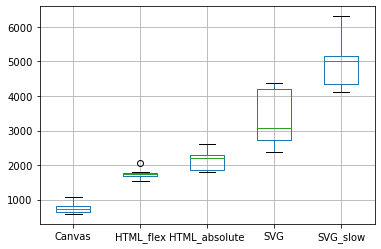

In [43]:
pivoted_data.boxplot(column=['Canvas', 'HTML_flex', 'HTML_absolute', 'SVG', 'SVG_slow'])
pivoted_data.describe()

Let's calculate the 95% confidence interval for the mean of the SVG/Canvas Ratio

(3.64997116486455, 5.178153142377049)

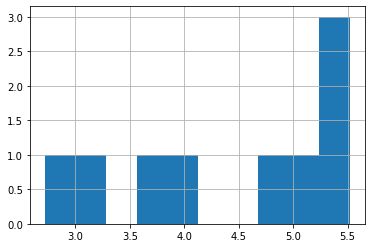

In [44]:
pivoted_data.SVG_Canvas_Ratio.hist()
stats.t.interval(
    alpha=.95, # Confidence level
    df=len(pivoted_data)-1, # Degrees of freedom
    loc=pivoted_data.SVG_Canvas_Ratio.mean(), # Interval around the mean
    scale=stats.sem(pivoted_data.SVG_Canvas_Ratio) # Based on Standard Error of Mean
)

This means that we are **95%** confident that the average ratio between the Canvas and the SVG method is between:
- **3,6** and **5,2 times** in the homogeneous dataset
- **5,2** and **9,3 times** in the heterogeneous dataset

This pre-supposes that the data is normally distributed.

### How significant is the performance difference between methods?

Using a paired-samples T-test

In [45]:
cols = ['HTML_flex', 'HTML_absolute', 'SVG', 'SVG_slow']
for i in range(len(cols)):
    for j in range(i):
        print(cols[i].ljust(15),' vs. ',cols[j],'\n\t',stats.ttest_rel(pivoted_data[cols[i]], pivoted_data[cols[j]]))

HTML_absolute    vs.  HTML_flex 
	 Ttest_relResult(statistic=5.015749487706037, pvalue=0.001032332630649833)
SVG              vs.  HTML_flex 
	 Ttest_relResult(statistic=5.8732976415833305, pvalue=0.000372814835591956)
SVG              vs.  HTML_absolute 
	 Ttest_relResult(statistic=3.416354405820121, pvalue=0.00913698744422596)
SVG_slow         vs.  HTML_flex 
	 Ttest_relResult(statistic=15.012635163111737, pvalue=3.828359719244016e-07)
SVG_slow         vs.  HTML_absolute 
	 Ttest_relResult(statistic=18.61430502992439, pvalue=7.157296765718531e-08)
SVG_slow         vs.  SVG 
	 Ttest_relResult(statistic=3.6743425798150664, pvalue=0.006270085801262519)


According to the paired sample T-test, all differences are significant. This works very well for the homogeneous dataset because it's all data from the same device under similar conditions and it's close enough to a normal distribution.

Let's also try the **Wilcoxon Sign-Rank test** - some of the p-values on the heterogeneous dataset will be even better.

In [46]:
cols = ['HTML_flex', 'HTML_absolute', 'SVG', 'SVG_slow']
for i in range(len(cols)):
    for j in range(i):
        print(cols[i].ljust(15),' vs. ',cols[j],'\n\t',stats.wilcoxon(pivoted_data[cols[i]], pivoted_data[cols[j]]))

HTML_absolute    vs.  HTML_flex 
	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
SVG              vs.  HTML_flex 
	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
SVG              vs.  HTML_absolute 
	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
SVG_slow         vs.  HTML_flex 
	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
SVG_slow         vs.  HTML_absolute 
	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
SVG_slow         vs.  SVG 
	 WilcoxonResult(statistic=6.0, pvalue=0.0546875)


### Which browser is faster on Windows?


Browser: count      36.000000
mean     1479.333333
std      1585.950495
min        31.000000
25%       316.750000
50%       609.000000
75%      2389.000000
max      6305.000000
Name: duration, dtype: float64

Browser: count      36.000000
mean     1422.805556
std      1522.234895
min        26.000000
25%       315.000000
50%       591.000000
75%      2385.500000
max      5769.000000
Name: duration, dtype: float64

Browser: count      36.000000
mean     1330.222222
std      1422.485895
min        35.000000
25%       306.500000
50%       779.500000
75%      1763.250000
max      4368.000000
Name: duration, dtype: float64


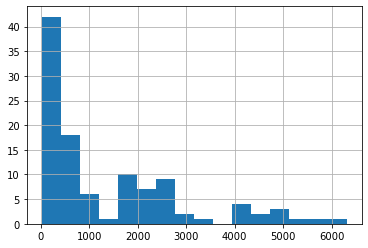

In [47]:
windows_data = dataset[dataset.os == 'Windows']
windows_data.duration.hist(bins=16)
for browser in ['Chrome', 'Edge', 'Firefox']:
    print('\nBrowser:',windows_data[windows_data.browser == browser].duration.describe())

In [48]:
print("Anova (when data is normally distributed)\n\t", stats.f_oneway(
    windows_data[windows_data.browser == 'Chrome'].duration,
    windows_data[windows_data.browser == 'Edge'].duration,
    windows_data[windows_data.browser == 'Firefox'].duration
))
print("Kruskal-Wallis Test (when it isn't)\n\t", stats.kruskal(
    windows_data[windows_data.browser == 'Chrome'].duration,
    windows_data[windows_data.browser == 'Edge'].duration,
    windows_data[windows_data.browser == 'Firefox'].duration
))

Anova (when data is normally distributed)
	 F_onewayResult(statistic=0.0892692409581662, pvalue=0.9146686305824163)
Kruskal-Wallis Test (when it isn't)
	 KruskalResult(statistic=0.034786926946387006, pvalue=0.9827569295980846)
